In [ ]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

In [10]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [ ]:
from pyFTS.common import Util as cUtil
from pyFTS.benchmarks import benchmarks as bchmk

from pyFTS.models import pwfts

from pyFTS.common import Transformations
tdiff = Transformations.Differential(1)

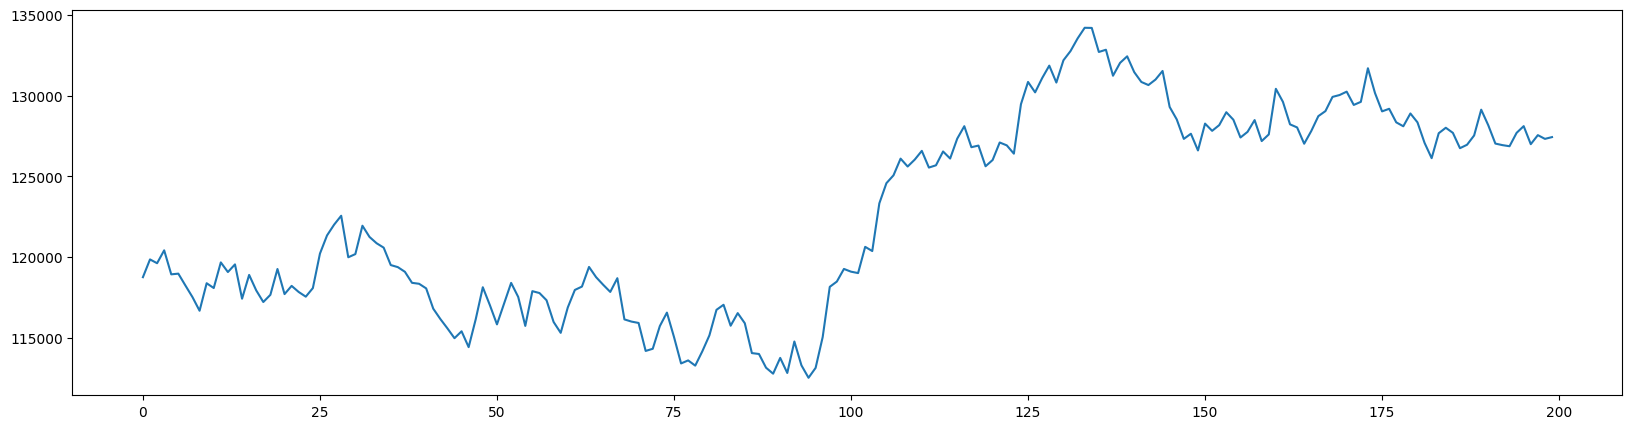

In [30]:
#Univariate time series
data = pd.read_csv('BVSP.csv', sep=',', compression='infer')
# data = np.array(teste['Close'])
# data


train = data['Close'].values[:200]
test = data['Close'].values[200:]

#Multivariate time series
import pandas as pd
data['Date'] = pd.to_datetime(data["Date"], format='%Y-%m-%d')
train_mv = data.iloc[:2000]
test_mv = data.iloc[2000:]

#Data visualization
import matplotlib.pyplot as plt
fig = plt.subplots(figsize=[20,5])
plt.plot(train)
pass

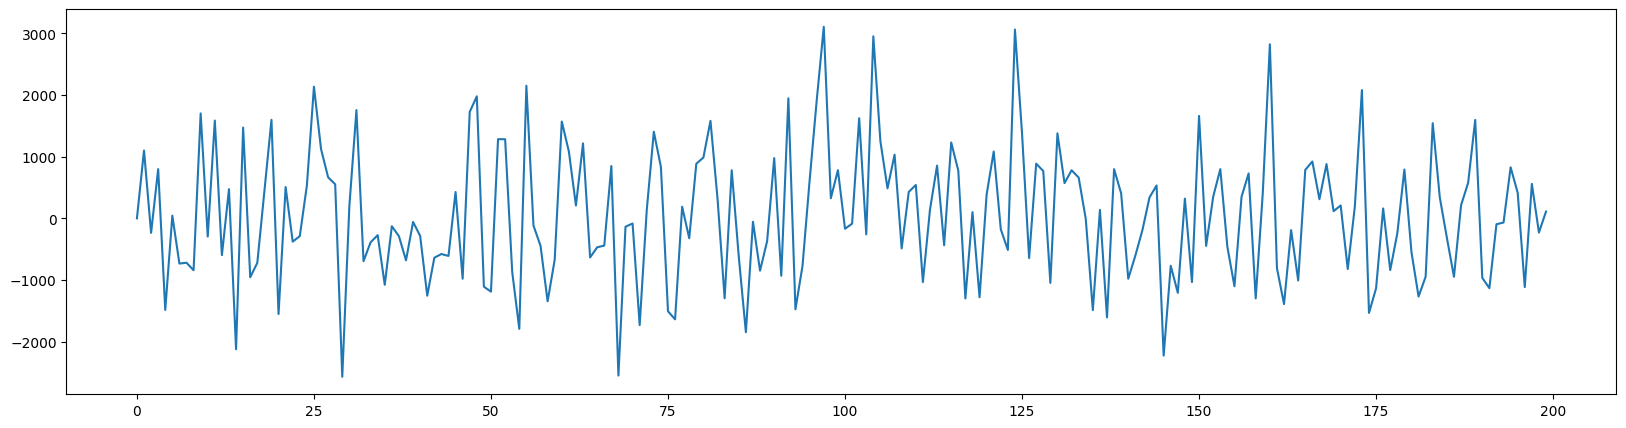

In [31]:
from pyFTS.common import Transformations
diff = Transformations.Differential(1)
fig = plt.subplots(figsize=[20,5])
plt.plot(diff.apply(train), label="glo_avg")
pass

c:\Dev\notebooks\.venv\lib\site-packages\pyFTS\partitioners\partitioner.py:239: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


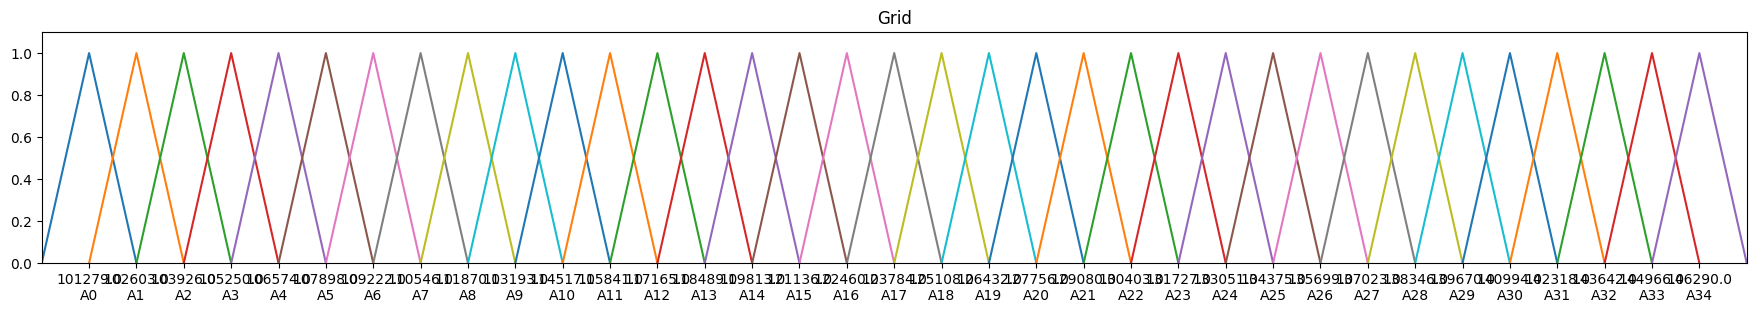

In [32]:
from pyFTS.partitioners import Grid
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[22,3])
part = Grid.GridPartitioner(data=train,npart=35)
part.plot(ax)

In [33]:
from pyFTS.common import FuzzySet as fz
F = fz.fuzzyfy_series(train, part.sets)
print(F)

['A13', 'A14', 'A14', 'A14', 'A13', 'A13', 'A13', 'A12', 'A12', 'A13', 'A13', 'A14', 'A13', 'A14', 'A12', 'A13', 'A13', 'A12', 'A12', 'A14', 'A12', 'A13', 'A13', 'A12', 'A13', 'A14', 'A15', 'A16', 'A16', 'A14', 'A14', 'A16', 'A15', 'A15', 'A15', 'A14', 'A14', 'A13', 'A13', 'A13', 'A13', 'A12', 'A11', 'A11', 'A10', 'A11', 'A10', 'A11', 'A13', 'A12', 'A11', 'A12', 'A13', 'A12', 'A11', 'A13', 'A12', 'A12', 'A11', 'A11', 'A12', 'A13', 'A13', 'A14', 'A13', 'A13', 'A13', 'A13', 'A11', 'A11', 'A11', 'A10', 'A10', 'A11', 'A12', 'A10', 'A9', 'A9', 'A9', 'A10', 'A10', 'A12', 'A12', 'A11', 'A12', 'A11', 'A10', 'A10', 'A9', 'A9', 'A9', 'A9', 'A10', 'A9', 'A9', 'A9', 'A10', 'A13', 'A13', 'A14', 'A13', 'A13', 'A15', 'A14', 'A17', 'A18', 'A18', 'A19', 'A18', 'A19', 'A19', 'A18', 'A18', 'A19', 'A19', 'A20', 'A20', 'A19', 'A19', 'A18', 'A19', 'A20', 'A19', 'A19', 'A21', 'A22', 'A22', 'A23', 'A23', 'A22', 'A23', 'A24', 'A24', 'A25', 'A25', 'A24', 'A24', 'A23', 'A23', 'A24', 'A23', 'A22', 'A22', 'A22', '

In [34]:
from pyFTS.common import FLR
rules = FLR.generate_non_recurrent_flrs(F)
print([str(k) for k in rules[0:10]])

['A13 -> A14', 'A14 -> A14', 'A14 -> A13', 'A13 -> A13', 'A13 -> A12', 'A12 -> A12', 'A12 -> A13', 'A14 -> A12', 'A12 -> A14', 'A14 -> A15']


In [35]:
from pyFTS.models import chen
model = chen.ConventionalFTS(partitioner=part)
model.fit(train)
print(model)

Conventional FTS:
A9 -> A10,A9
A10 -> A10,A11,A12,A13,A9
A11 -> A10,A11,A12,A13
A12 -> A10,A11,A12,A13,A14
A13 -> A11,A12,A13,A14,A15
A14 -> A12,A13,A14,A15,A16,A17
A15 -> A14,A15,A16
A16 -> A14,A15,A16
A17 -> A18
A18 -> A18,A19
A19 -> A18,A19,A20,A21
A20 -> A19,A20,A21,A22
A21 -> A20,A21,A22,A23
A22 -> A21,A22,A23
A23 -> A21,A22,A23,A24
A24 -> A23,A24,A25
A25 -> A24,A25



In [36]:
from pyFTS.common import FuzzySet as fz
f = fz.get_maximum_membership_fuzzyset(130000, part.sets)
print(f)

A22: trimf([129079.55999999987, 130403.40571428557, 131727.2514285713])


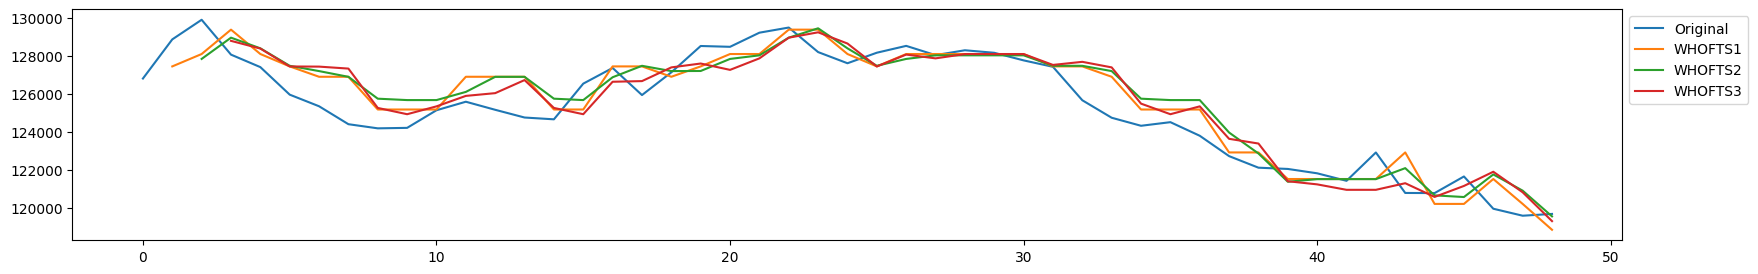

In [39]:
from pyFTS.common import Util
from pyFTS.models import hofts, pwfts
import numpy as np

models = []
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,3])
ax.plot(test[:100], label='Original')
rows = []
for method in [hofts.WeightedHighOrderFTS]:    # , hofts.WeightedHighOrderFTS, pwfts.ProbabilisticWeightedFTS
  for order in [1, 2, 3]:
    model = method(partitioner=part, order=order)
    model.shortname += str(order)
    model.fit(train)
    forecasts = model.predict(test)
    for k in np.arange(order):
      forecasts.insert(0,None)
    ax.plot(forecasts[:100], label=model.shortname)
    models.append(model.shortname)
    Util.persist_obj(model, model.shortname)
    del(model)
handles, labels = ax.get_legend_handles_labels()
gd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

In [40]:
forecasts

[None,
 None,
 None,
 128780.11870748286,
 128374.1578963584,
 127429.45056972778,
 127422.58980098332,
 127318.49681954875,
 125245.92345238084,
 124914.9620238094,
 125328.6638095237,
 125880.26619047608,
 126025.06181547607,
 126713.1132064535,
 125245.92345238084,
 124914.9620238094,
 126624.92940476177,
 126659.40455357131,
 127381.57135267503,
 127585.62265369293,
 127250.92857743084,
 127857.2276650659,
 128947.10379189844,
 129230.06864965973,
 128639.06609863932,
 127429.45056972778,
 128057.11616085656,
 127857.2276650659,
 128083.31300458353,
 128083.31300458353,
 128083.31300458353,
 127511.69212676362,
 127674.41909851285,
 127381.57135267503,
 125472.08042857131,
 124914.9620238094,
 125328.6638095237,
 123618.69642857132,
 123370.47535714274,
 121384.7067857142,
 121219.22607142848,
 120932.39283333323,
 120932.39283333323,
 121279.90233333324,
 120557.30321428562,
 121136.48571428562,
 121883.9069404761,
 120802.76627380942,
 119283.10171428563]

# part 2
